<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Training-dataset" data-toc-modified-id="Training-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training dataset</a></span><ul class="toc-item"><li><span><a href="#First-look" data-toc-modified-id="First-look-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>First look</a></span></li><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#Filling-the-missing-values" data-toc-modified-id="Filling-the-missing-values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Filling the missing values</a></span></li><li><span><a href="#Encoding-the-categorical-values" data-toc-modified-id="Encoding-the-categorical-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Encoding the categorical values</a></span></li><li><span><a href="#Training-some-algorithms" data-toc-modified-id="Training-some-algorithms-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Training some algorithms</a></span><ul class="toc-item"><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Train-test split</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.5.3"><span class="toc-item-num">2.5.3&nbsp;&nbsp;</span>Logistic Regression</a></span></li></ul></li></ul></li><li><span><a href="#Generating-predictions-on-the-test-set" data-toc-modified-id="Generating-predictions-on-the-test-set-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating predictions on the test set</a></span><ul class="toc-item"><li><span><a href="#Filling-the-missing-values" data-toc-modified-id="Filling-the-missing-values-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filling the missing values</a></span></li><li><span><a href="#Encoding-the-categorical-values" data-toc-modified-id="Encoding-the-categorical-values-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Encoding the categorical values</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Predictions</a></span></li></ul></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Next steps</a></span></li></ul></div>

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Training dataset

## First look

In [2]:
train_df = pd.read_csv("train_auto.csv", index_col=0)
print(train_df.shape)
train_df.sample().T

(8161, 25)


INDEX,24
TARGET_FLAG,0
TARGET_AMT,0.0
KIDSDRIV,0
AGE,31.0
HOMEKIDS,2
YOJ,12.0
INCOME,"$18,903"
PARENT1,No
HOME_VAL,"$93,797"
MSTATUS,Yes


In [3]:
# First look at the target column
train_df["TARGET_FLAG"].value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

We notice that there are 25 columns, including 2 target columns, so 23 feature columns.  
Most of the feature names are quite explicit, even though a few of them are not really clear to me (TIF, YOJ and MVR_PTS).   
We will first do some data exploration and visualization, but this first glance at the dataset gives us a few hints for the processing and modelling steps:  
- we will have to parse the INCOME, HOME_VAL, BLUEBOOK and OLD_CLAIM columns to remove the $ sign  
- we will have to encode the categorical variables before fitting models  
- the high number of features imply that an algorithm such as KNN should not be chosen   
- we note that the target column is unbalanced (~75% of negative labels), this means that we will have to choose a suitable metric (not the accuracy for instance)  

In [4]:
# Drop the auxiliary target column
train_df = train_df.drop(["TARGET_AMT"], axis=1)

In [5]:
# Check for NaNs
train_df.isna().sum()

TARGET_FLAG      0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

In [6]:
print(len(train_df[train_df.isna().any(axis=1)]))

2116


There are six columns with NaNs, one (AGE) with only 6 missing records, and the other ones with 400-500 missing records. Besides, this is not the same subset of rows that have NaNs in all these columns, but instead the NaNs are scattered across more than 2000 rows of the dataset. Therefore, we cannot drop the rows with NaNs (we could have imagined do that for a quick first pass if the number of rows with missing values were smaller), so we will have to impute the missing values.  
But before that, we will explore the dataset.  

## Data exploration

First, we remove the dollar signs from the money columns and cast the values to float

In [7]:
def dollar_amount_to_float(amount):
    if not isinstance(amount, str) and np.isnan(amount):
        return np.nan
    return float(amount[1:].strip().replace(",", ""))

train_df["INCOME"] = train_df["INCOME"].apply(dollar_amount_to_float)
train_df["HOME_VAL"] = train_df["HOME_VAL"].apply(dollar_amount_to_float)
train_df["BLUEBOOK"] = train_df["BLUEBOOK"].apply(dollar_amount_to_float)
train_df["OLDCLAIM"] = train_df["OLDCLAIM"].apply(dollar_amount_to_float)

Now, we plot the distribution of each column (and the value repartition for the categorical columns)

Column: KIDSDRIV


<BarContainer object of 5 artists>

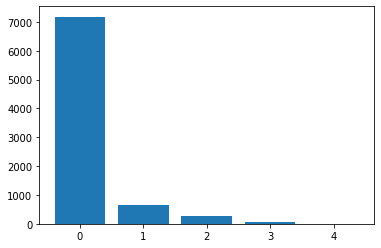

Column: AGE


<AxesSubplot:ylabel='Frequency'>

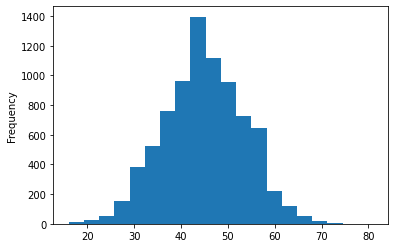

Column: HOMEKIDS


<AxesSubplot:ylabel='Frequency'>

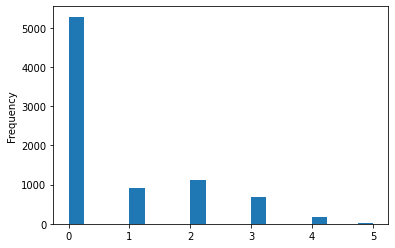

Column: YOJ


<AxesSubplot:ylabel='Frequency'>

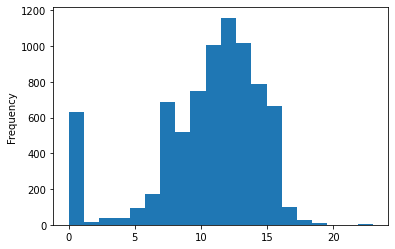

Column: INCOME


<AxesSubplot:ylabel='Frequency'>

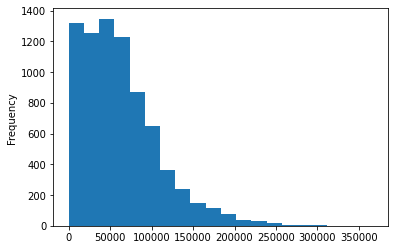

Column: PARENT1


<BarContainer object of 2 artists>

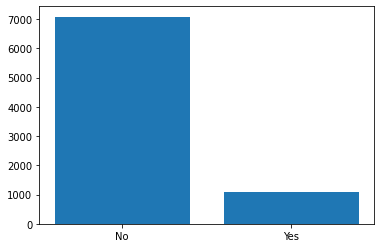

Column: HOME_VAL


<AxesSubplot:ylabel='Frequency'>

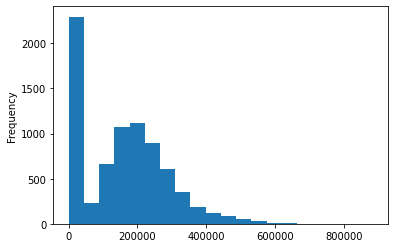

Column: MSTATUS


<BarContainer object of 2 artists>

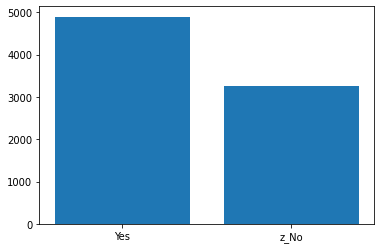

Column: SEX


<BarContainer object of 2 artists>

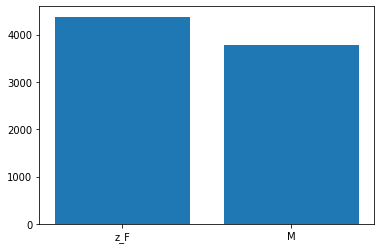

Column: EDUCATION


<BarContainer object of 5 artists>

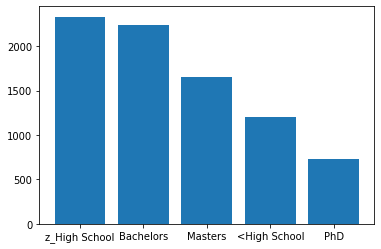

Column: JOB


<BarContainer object of 8 artists>

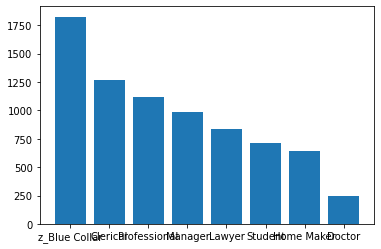

Column: TRAVTIME


<AxesSubplot:ylabel='Frequency'>

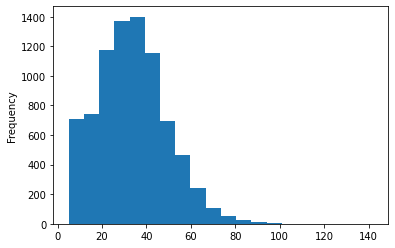

Column: CAR_USE


<BarContainer object of 2 artists>

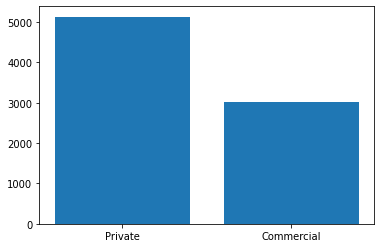

Column: BLUEBOOK


<AxesSubplot:ylabel='Frequency'>

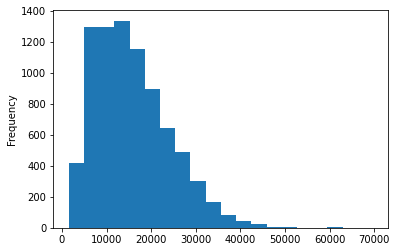

Column: TIF


<AxesSubplot:ylabel='Frequency'>

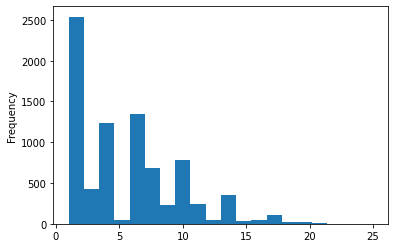

Column: CAR_TYPE


<BarContainer object of 6 artists>

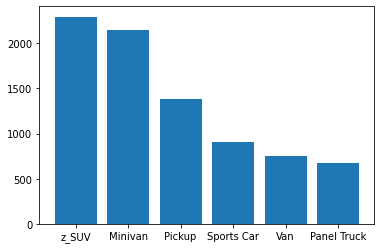

Column: RED_CAR


<BarContainer object of 2 artists>

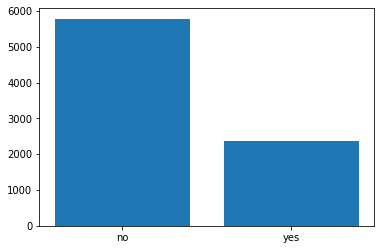

Column: OLDCLAIM


<AxesSubplot:ylabel='Frequency'>

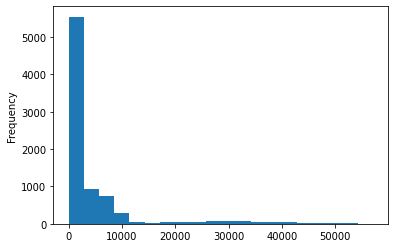

Column: CLM_FREQ


<AxesSubplot:ylabel='Frequency'>

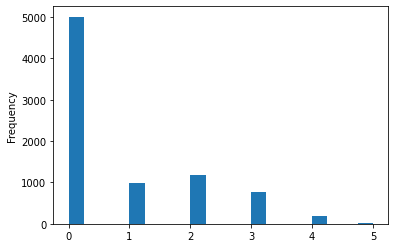

Column: REVOKED


<BarContainer object of 2 artists>

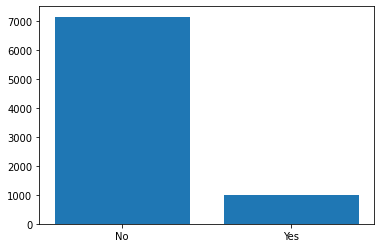

Column: MVR_PTS


<AxesSubplot:ylabel='Frequency'>

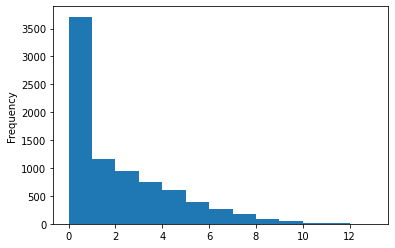

Column: CAR_AGE


<AxesSubplot:ylabel='Frequency'>

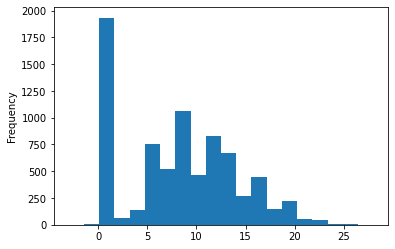

Column: URBANICITY


<BarContainer object of 2 artists>

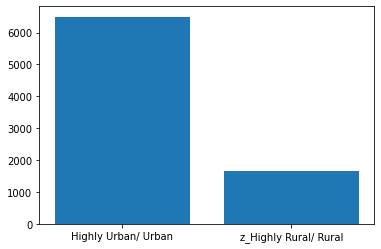

In [8]:
for col in train_df.columns:
    if col == "TARGET_FLAG":
        continue
    print(f"Column: {col}")
    if col in ["KIDSDRIV", "PARENT1", "MSTATUS", "SEX", "EDUCATION", "JOB",
            "CAR_USE", "CAR_TYPE", "RED_CAR", "REVOKED", "URBANICITY"]:
        counts = train_df[col].value_counts()
        plt.bar(x=counts.index, height=counts.values)
        plt.show()
    else:
        if col == "MVR_PTS":
            train_df[col].plot.hist(bins=13)
        else:
            train_df[col].plot.hist(bins=20)
        plt.show()

Some observations:  
- some column distributions exhibit a peak at the first bin, and then a bell curve (eg, columns YOJ, HOME_VAL, CAR_AGE): this may denote specific profiles.  
- we notice that one value of CAR_AGE is negative, this cannot physically happen, so we will set it to 0.   
- some columns have lots of 0s, and then few positive values (eg, columns KIDSDRIV, HOMEKIDS, CLM_FREQ, MVR_PTS)   

In [9]:
# "Correct" the CAR_AGE negative value
train_df.loc[train_df["CAR_AGE"] < 0, "CAR_AGE"] = 0

Now we plot the correlation between all the numerical features  

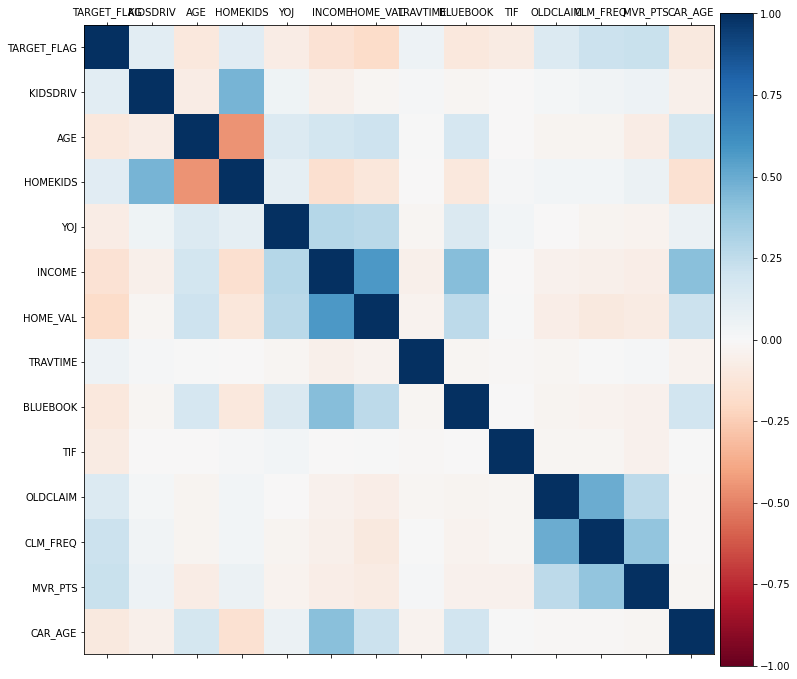

In [10]:
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.matshow(corr, cmap="RdBu", vmin=-1, vmax=1)
_ = plt.xticks(range(len(corr.columns)), corr.columns)
_ = plt.yticks(range(len(corr.columns)), corr.columns)
cbar = fig.colorbar(cax, fraction=0.05, pad=0.01)
plt.show()

We notice that: 
- no feature column is strongly correlated (or anti-correlated) with the target column  
- some feature columns exhibit some correlation: 
    - HOMEKIDS and KIDSDRIVE are positively correlated (this was to be expected)  
    - AGE and HOMEKIDS are negatively correlated (this was to be expected)  
    - INCOME is strongly correlated with HOME_VAL (this was to be expected), and moderately correlated with BLUEBOOK (this could have been expected too), YOJ and CAR_AGE  
    - OLD_CLAIM is strongly correlated with CLM_FREQ (this was to be expected), and moderately correlated with MVR_PTS     

Now, for the categorical variables, we plot the repartition of the target for each class.

PARENT1


<AxesSubplot:xlabel='PARENT1'>

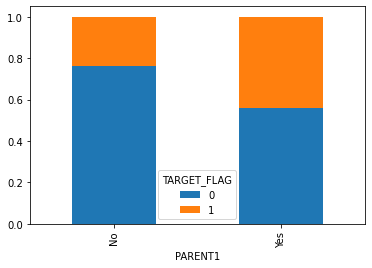

MSTATUS


<AxesSubplot:xlabel='MSTATUS'>

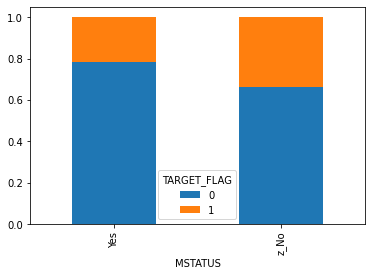

SEX


<AxesSubplot:xlabel='SEX'>

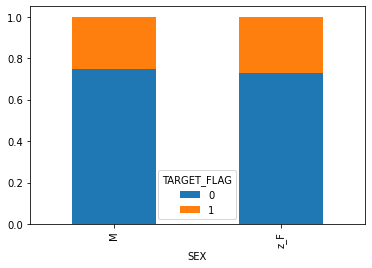

CAR_USE


<AxesSubplot:xlabel='CAR_USE'>

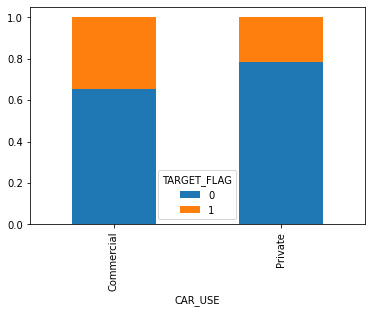

RED_CAR


<AxesSubplot:xlabel='RED_CAR'>

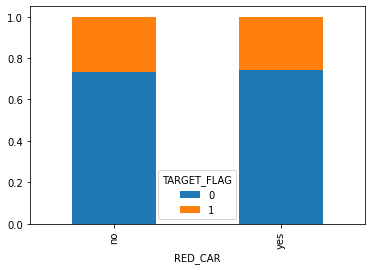

REVOKED


<AxesSubplot:xlabel='REVOKED'>

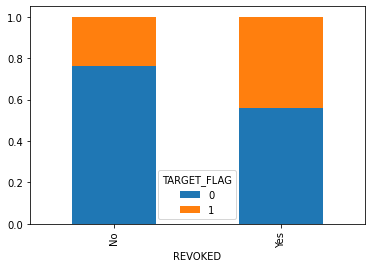

URBANICITY


<AxesSubplot:xlabel='URBANICITY'>

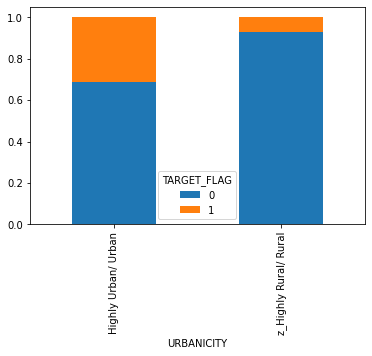

EDUCATION


<AxesSubplot:xlabel='EDUCATION'>

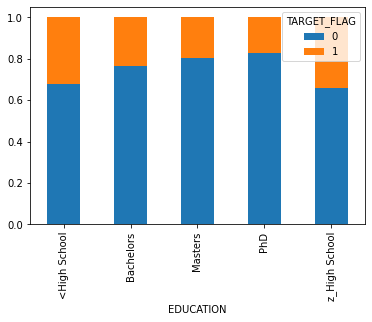

JOB


<AxesSubplot:xlabel='JOB'>

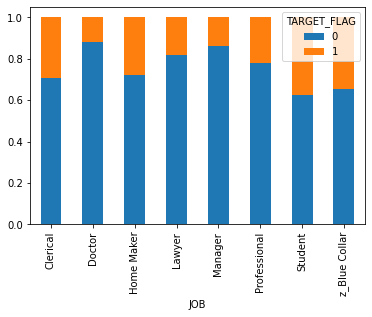

CAR_TYPE


<AxesSubplot:xlabel='CAR_TYPE'>

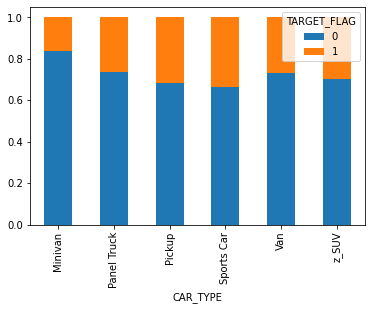

In [11]:
for col in ["PARENT1", "MSTATUS", "SEX", "CAR_USE", "RED_CAR", "REVOKED",
            "URBANICITY", "EDUCATION", "JOB", "CAR_TYPE"]:
    print(col)
    pd.crosstab(train_df[col], train_df["TARGET_FLAG"],
                normalize="index").plot.bar(stacked=True)
    plt.show()

Only the SEX and RED_CAR columns show a nearly identical repartition of the target for each class.    

## Filling the missing values

The first idea I have to fill missing values is to use the median of each columns.  
Before doing so, for each column with missing values, we will plot the distribution of the column with the median and the mean (except for the JOB column because it is non-numerical).  

AGE
nb of NaNs: 6
mean: 44.79031269160024 ; median: 45.0


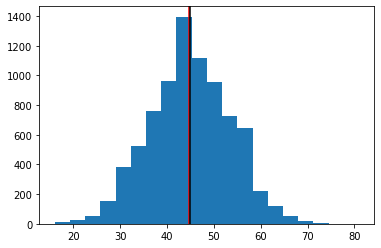

YOJ
nb of NaNs: 454
mean: 10.499286363046581 ; median: 11.0


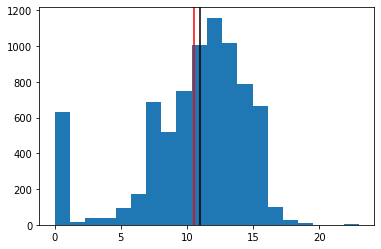

INCOME
nb of NaNs: 445
mean: 61898.0946086055 ; median: 54028.0


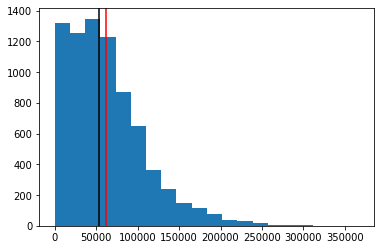

HOME_VAL
nb of NaNs: 464
mean: 154867.2897232688 ; median: 161160.0


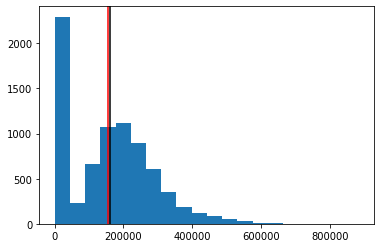

CAR_AGE
nb of NaNs: 510
mean: 8.32871520062737 ; median: 8.0


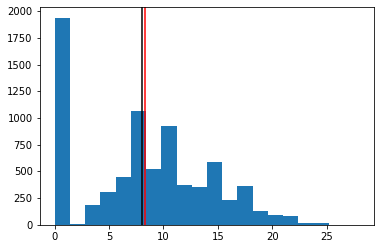

In [12]:
for col in ["AGE", "YOJ", "INCOME", "HOME_VAL", "CAR_AGE"]:
    print(col)
    print(f"nb of NaNs: {train_df[col].isna().sum()}")
    print(f"mean: {train_df[col].mean()} ; median: {train_df[col].median()}")
    _ = plt.hist(x=train_df[col].values, bins=20)
    _ = plt.axvline(x=train_df[col].mean(), color="red")
    _ = plt.axvline(x=train_df[col].median(), color="black")
    plt.show()

We will fill the AGE column with the median.   
For the other columns, there is this 0-peak in the distribution that may indicate specific driver profiles, so we could think of more complex solutions that just using the median of the column to impute missing values.  
First, we save the medians of each column, so that they don't get contaminated by the imputing strategy, and can be applied to fill potential missing values in the test dataset (we also save the modes, because the JOB column has missing values too).   

In [13]:
train_medians = train_df.median()
train_mode = train_df.mode()

In [14]:
# Fill the AGE column
train_df["AGE"] = train_df["AGE"].fillna(value=train_medians["AGE"])

Next, some of the colums with missing values have frequency peaks around 0, and those could be linked: for instance, a driver with no income (INCOME = 0), can be expected to have a HOME_VAL of 0 (expect some cases such as inheritors). Besides, these columns showed some correlation between each other.  
Let's see if such patterns appear in the data. 

Number of records where INCOME = 0: 615
HOME_VAL when INCOME = 0
mean: 38314.617647058825 ; median: 0.0


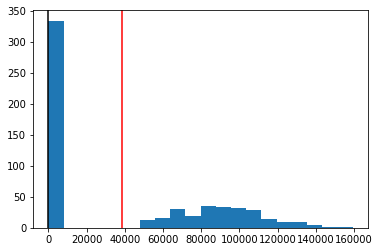

YOJ when INCOME = 0
mean: 0.0 ; median: 0.0


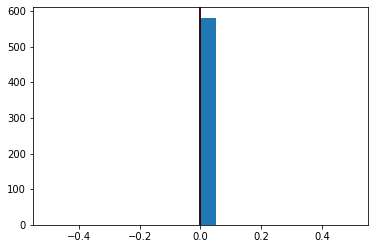

Number of records where HOME_VAL = 0: 2294
INCOME when HOME_VAL = 0
mean: 53459.89935661765 ; median: 44494.5


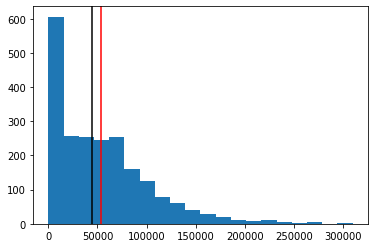

YOJ when HOME_VAL = 0
mean: 9.117972350230415 ; median: 10.0


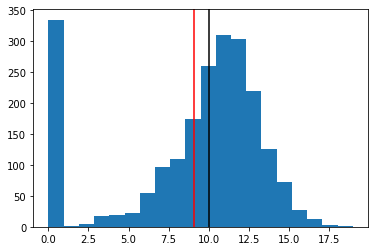

Number of records where YOJ = 0: 625
INCOME when YOJ = 0
mean: 94.0 ; median: 0.0


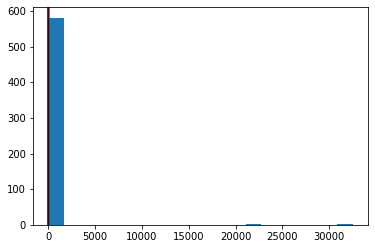

HOME_VAL when YOJ = 0
mean: 40159.680887372015 ; median: 0.0


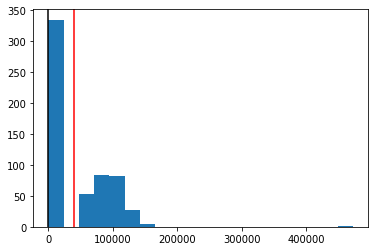

In [15]:
for col in ["INCOME", "HOME_VAL", "YOJ"]:
    tmp_df = train_df[train_df[col] == 0]
    print(f"Number of records where {col} = 0: {len(tmp_df[col])}")
    for col_bis in ["INCOME", "HOME_VAL", "YOJ"]:
        if col == col_bis:
            continue
        else:
            print(f"{col_bis} when {col} = 0")
            print(f"mean: {tmp_df[col_bis].mean()} ; median: {tmp_df[col_bis].median()}")
            _ = plt.hist(x=tmp_df[col_bis].values, bins=20)
            _ = plt.axvline(x=tmp_df[col_bis].mean(), color="red")
            _ = plt.axvline(x=tmp_df[col_bis].median(), color="black")
            plt.show()

We can indeed see in the plots above that: 
- YOJ is 0 when INCOME is 0, and the opposite holds too (INCOME is 0 when YOJ is 0)  
- More than half of the HOME_VAL values are 0 when INCOME is 0  
- More than half of the HOME_VAL values are 0 when YOJ is 0    

Therefore, we will first fill some missing values using these observations, before filling the remaining missing values using the column median (previously computed).   
However, before doing so, we will first look at the JOB column repartition, because those columns (YOJ, INCOME and HOME_VAl) may have an impact on it. For instance, we can expect more "Students" when INCOME or HOME_VAL are 0.  

<BarContainer object of 8 artists>

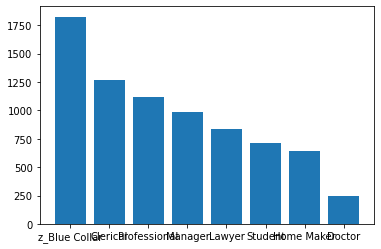

In [16]:
counts = train_df["JOB"].value_counts()
plt.bar(x=counts.index, height=counts.values)
plt.show()

When INCOME = 0


<BarContainer object of 8 artists>

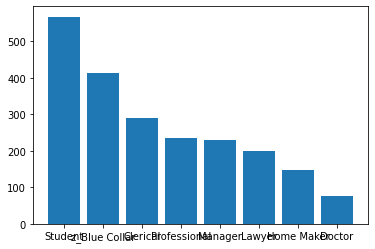

When HOME_VAL = 0


<BarContainer object of 8 artists>

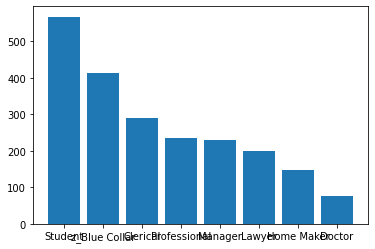

When YOJ = 0


<BarContainer object of 8 artists>

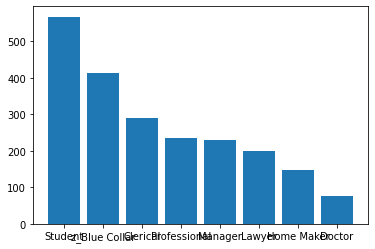

In [17]:
for col in ["INCOME", "HOME_VAL", "YOJ"]:
    print(f"When {col} = 0")
    counts = train_df[train_df["HOME_VAL"] == 0]["JOB"].value_counts()
    plt.bar(x=counts.index, height=counts.values)
    plt.show()

The most frequent JOB class is overall blue-collar worker, however when INCOME, HOME_VAL or YOJ is 0, the most frequent class is student.  
We will use that as well to fill the values for that column.  

In [18]:
# Filling using the observations we made
train_df.loc[(train_df["INCOME"].isna()) & (train_df["YOJ"] == 0), "INCOME"] = 0
train_df.loc[(train_df["YOJ"].isna()) & (train_df["INCOME"] == 0), "YOJ"] = 0
train_df.loc[(train_df["HOME_VAL"].isna()) &
             ((train_df["INCOME"] == 0) | (train_df['YOJ'] == 0)), "HOME_VAL"] = 0
train_df.loc[(train_df["JOB"].isna()) &
             ((train_df["INCOME"] == 0) |
              (train_df['YOJ'] == 0) |
              (train_df["HOME_VAL"] == 0)), "JOB"] = "Student"

# Filling the remaining with the median or mode
for col in ["INCOME", "HOME_VAL", "YOJ", "CAR_AGE"]:
    train_df[col] = train_df[col].fillna(train_medians[col])
train_df["JOB"] = train_df["JOB"].fillna(train_mode["JOB"][0])

In [19]:
# Sanity check
assert train_df.isna().sum().sum() == 0

## Encoding the categorical values

The last step before training a Machine Learning algorithm is to encode the categorical variables into numerical ones.  
To do so, we will use the One-Hot Encoder provided by scikit-learn.  

In [20]:
# We use drop="first" to avoid creating collinear variables  
ohe = OneHotEncoder(drop="first", sparse=False)
COLS_TO_ENCODE = ["PARENT1", "MSTATUS", "SEX", "EDUCATION", "JOB", "CAR_USE",
                  "CAR_TYPE", "RED_CAR", "REVOKED", "URBANICITY"]
to_encode_train = train_df[COLS_TO_ENCODE]
ohe.fit(to_encode_train.values)
train_encoded = ohe.transform(to_encode_train.values)

OneHotEncoder(drop='first', sparse=False)

In [21]:
# Now we drop the categorical columns and add the encoded ones
train_df = train_df.drop(COLS_TO_ENCODE, axis=1)
train_df = pd.concat([train_df.reset_index(drop=True),
                      pd.DataFrame(train_encoded)], axis=1)
# Visual check
train_df.sample().T

,4972
TARGET_FLAG,0.0
KIDSDRIV,0.0
AGE,46.0
HOMEKIDS,0.0
YOJ,6.0
INCOME,182650.0
HOME_VAL,419730.0
TRAVTIME,59.0
BLUEBOOK,34540.0
TIF,1.0


## Training some algorithms 

This binary classification seems suited for classic Machine Learning algorithms, so we will try a few of them.   
To assess the performance of the algorithms, we will split the dataset into a training and a validation set.  
As the target is unbalanced, we will use the F1-score and the confustion matrix as metrics.  

### Train-test split

First, we split the current dataset into a training set and a validation set. 

In [22]:
target = train_df["TARGET_FLAG"]
train_vals = train_df.drop(["TARGET_FLAG"], axis=1).values

X_train, X_valid, y_train, y_valid = train_test_split(train_vals, target,
                                                      test_size=0.25, stratify=target)

In [23]:
def plot_confusion_matrix(cm, classes=[0, 1], cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Random Forest

In [24]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, n_jobs=4)
rfc.fit(X=X_train, y=y_train)
y_pred_train = rfc.predict(X_train)
y_pred_valid = rfc.predict(X_valid)

RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=4)

F1-score on training set : 0.7307392996108949
F1-score on validation set : 0.42392717815344605


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

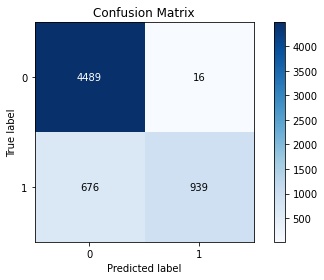

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

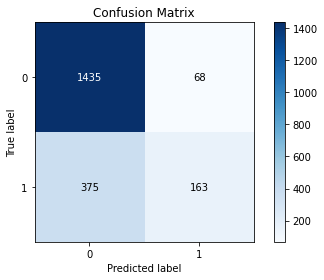

In [25]:
print(f"F1-score on training set : {f1_score(y_true=y_train, y_pred=y_pred_train)}")
print(f"F1-score on validation set : {f1_score(y_true=y_valid, y_pred=y_pred_valid)}")

plot_confusion_matrix(cm=confusion_matrix(y_true=y_train, y_pred=y_pred_train))
plt.show()
plot_confusion_matrix(cm=confusion_matrix(y_true=y_valid, y_pred=y_pred_valid))
plt.show()

These parameters for the Random Forest give us a baseline.  
Even on the training set, there are many misclassification errors, especially False Negatives (1s being predicted as 0s).   

We will try to play a bit on the max_depth parameter. We also know that we could increase the number of trees (n_estimators), which should yield better results, however this means more computation time and memory use for a marginal gain.   

In [26]:
param_grid = {'max_depth' : [5, 10, 15, 20],
             'min_samples_split': [2, 4, 8]}

rfc = RandomForestClassifier(n_estimators=200, n_jobs=4)
gscv = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring="f1", cv=4,
                    n_jobs=4, refit=True)
gscv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(n_estimators=200, n_jobs=4),
             n_jobs=4,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 4, 8]},
             scoring='f1')

In [27]:
gscv.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=200,
                       n_jobs=4)

The best estimator is the one where trees can grow up to a depth of 20. As this is the maximum depth we allowed in our grid search parameters, we could try later a new Grid Search with higher values for the depth.    

In [28]:
y_pred_train = gscv.best_estimator_.predict(X_train)
y_pred_valid = gscv.best_estimator_.predict(X_valid)

F1-score on training set : 0.9868255959849436
F1-score on validation set : 0.4768683274021352


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

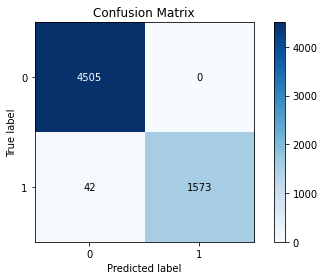

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

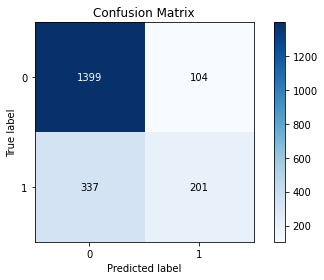

In [29]:
print(f"F1-score on training set : {f1_score(y_true=y_train, y_pred=y_pred_train)}")
print(f"F1-score on validation set : {f1_score(y_true=y_valid, y_pred=y_pred_valid)}")

plot_confusion_matrix(cm=confusion_matrix(y_true=y_train, y_pred=y_pred_train))
plt.show()
plot_confusion_matrix(cm=confusion_matrix(y_true=y_valid, y_pred=y_pred_valid))
plt.show()

The classification is way better on the training set (with nearly no False Positives), with still a lot of misclassified samples in the validation set.  
Yet, the score on the validation set improved from the baseline.  

### Logistic Regression

As this algorithm (at least the implementation in scikit-learn) uses regularization, we need to scale the features first

In [30]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

StandardScaler()

In [31]:
lr = LogisticRegression(n_jobs=4)
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)
y_pred_valid = lr.predict(X_valid_scaled)

LogisticRegression(n_jobs=4)

F1-score on training set : 0.5269143290371493
F1-score on validation set : 0.5005688282138793


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

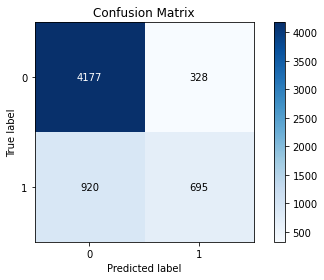

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

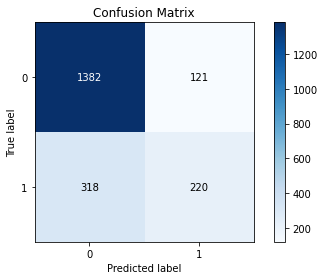

In [32]:
print(f"F1-score on training set : {f1_score(y_true=y_train, y_pred=y_pred_train)}")
print(f"F1-score on validation set : {f1_score(y_true=y_valid, y_pred=y_pred_valid)}")

plot_confusion_matrix(cm=confusion_matrix(y_true=y_train, y_pred=y_pred_train))
plt.show()
plot_confusion_matrix(cm=confusion_matrix(y_true=y_valid, y_pred=y_pred_valid))
plt.show()

This model yields better results on the validation set than the Random Forest did (even after some quick hyperparameter tuning).  
Besides, this model yields quite similar F1-scores on the training and on the validation set, which is a good sign. 

# Generating predictions on the test set

We will have to apply the same transformation to this dataset as we did on the training one. 
That is, filling the missing values in the same way, and using the same encoder and scaler.  

In [33]:
test_df = pd.read_csv("test_auto.csv", index_col=0)
print(test_df.shape)
test_df.sample().T

(2141, 25)


INDEX,9115
TARGET_FLAG,NaN
TARGET_AMT,NaN
KIDSDRIV,0
AGE,52.0
HOMEKIDS,0
YOJ,11.0
INCOME,"$41,408"
PARENT1,No
HOME_VAL,"$199,056"
MSTATUS,z_No


In [34]:
# Removing the dollar sign and casting the money columns to float
test_df["INCOME"] = test_df["INCOME"].apply(dollar_amount_to_float)
test_df["HOME_VAL"] = test_df["HOME_VAL"].apply(dollar_amount_to_float)
test_df["BLUEBOOK"] = test_df["BLUEBOOK"].apply(dollar_amount_to_float)
test_df["OLDCLAIM"] = test_df["OLDCLAIM"].apply(dollar_amount_to_float)

In [35]:
# Dropping the target columns
test_df = test_df.drop(["TARGET_FLAG", "TARGET_AMT"], axis=1)

In [36]:
# We keep the index to save the test predictions later
test_index = test_df.index

## Filling the missing values

In [37]:
# Looking for missing values
test_df.isna().sum()

KIDSDRIV        0
AGE             1
HOMEKIDS        0
YOJ            94
INCOME        125
PARENT1         0
HOME_VAL      111
MSTATUS         0
SEX             0
EDUCATION       0
JOB           139
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CAR_AGE       129
URBANICITY      0
dtype: int64

The columns with missing values are the same as for the training set.  
We will use the same rules as before to fill those, by taking care of using the values (median and mode of the train set), ie:
- fill the AGE with the median (from the training set)   
- set YOJ to 0 if INCOME is 0 and the opposite  
- set HOME_VAL to 0 if INCOME or YOJ is 0  
- set JOB to student if INCOME or YOJ or HOME_VAL is 0  
- fill the remaining missing values with the median (from the training set) for INCOME, YOJ, HOME_VAL, CAR_AGE, and with the mode (from the training set) for JOB

In [38]:
# Fill the AGE column
test_df["AGE"] = test_df["AGE"].fillna(value=train_medians["AGE"])

# Filling using the observations we made
test_df.loc[(test_df["INCOME"].isna()) & (test_df["YOJ"] == 0), "INCOME"] = 0
test_df.loc[(test_df["YOJ"].isna()) & (test_df["INCOME"] == 0), "YOJ"] = 0
test_df.loc[(test_df["HOME_VAL"].isna()) &
            ((test_df["INCOME"] == 0) | (test_df['YOJ'] == 0)), "HOME_VAL"] = 0
test_df.loc[(test_df["JOB"].isna()) &
             ((test_df["INCOME"] == 0) |
              (test_df['YOJ'] == 0) |
              (test_df["HOME_VAL"] == 0)), "JOB"] = "Student"

# Filling the remaining with the median or mode
for col in ["INCOME", "HOME_VAL", "YOJ", "CAR_AGE"]:
    test_df[col] = test_df[col].fillna(train_medians[col])
test_df["JOB"] = test_df["JOB"].fillna(train_mode["JOB"][0])

## Encoding the categorical values

We re-use the encoder that was "fitted" on the training set. 

In [39]:
to_encode_test = test_df[COLS_TO_ENCODE]
test_encoded = ohe.transform(to_encode_test.values)

# Now we drop the categorical columns and add the encoded ones
test_df = test_df.drop(COLS_TO_ENCODE, axis=1)
test_df = pd.concat([test_df.reset_index(drop=True),
                      pd.DataFrame(test_encoded)], axis=1)
# Visual check
test_df.sample().T

,987
KIDSDRIV,0.0
AGE,44.0
HOMEKIDS,3.0
YOJ,17.0
INCOME,49098.0
HOME_VAL,157404.0
TRAVTIME,33.0
BLUEBOOK,5900.0
TIF,1.0
OLDCLAIM,0.0


## Predictions

I will use the Logistic Regression model trained before to predict the target on the test set, because it is the model that gave the best metric (F1-score) on the validation set.  

In [40]:
test_vals = test_df.values
# Sanity check
assert test_vals.shape[1] == train_vals.shape[1]

In [41]:
X_test_scaled = scaler.transform(test_vals)
y_test_pred = lr.predict(X_test_scaled)

In [42]:
# Save predictions to CSV
pd.DataFrame(data={"PREDICTION": y_test_pred},
             index=test_index).to_csv("test_predictions.csv")

# Next steps

To keep on improving the predictions with more time, I have a few more ideas.  

First, given that the two models we trained have different characteristics (the Random Forest one has fewer False Positives, and the Logistic Regression one has fewer False Negatives), we could try to combine the results of both models. In the same idea, we could as well try to train additional models.  

As the target is unbalanced and the dataset contains fewer positive samples, we could also try to use some oversampling techniques so that the Machine Learning algorithm is fed with more positive examples during the training phase.  

We could also come back to the feature engineering step. For instance, we could "binarize" the features having mostly 0s (such as KIDSDRIV, HOMEKIDS and MVR_PTS), in order to put the emphasis on whether or not this value is 0.  

Finally, we could also do a new pass on the imputing step. For instance, we could use some Machine Learning algorithms to predict the missing features, using the other featuures. However, such approach would add more complexity to the whole process.  